## ***Visión por Computadora - 2024***

Stefano Aragoni, Carol Arévalo, José González, Luis Santos

-----------

### *Proyecto 01 - Problema 1*

A partir de las imágenes groundtruth, construir un algoritmo que genere una discretización de la estructura arterial. Representaremos esta discretizaiónn mediante un grafo de vértices y aristas que conectan dichos vértices.

Su algoritmo debe recibir como input la imagen groundtruth, y los par´ametros espec´ıficos que sus m´etodos y estrategias requieran.

Como salida, el algoritmo debe devolver lo siguiente:

1.) Un archivo estructurado (puede ser en formato .json, .yml, o similares), en donde se especifica la estructura del grafo
obtenido:
- listado de nodos, y sus coordenadas (fila, columna) dentro de la imagen groundtruth.
- listado de nodos extremos (indicados en verde en la figura).
- listado de nodos de bifurcación (indicados en rojo en la figura).
- listado de nodos de trifurcación (indicados en azul, en la figura no hay).
- listado de nodos intermedios (indicados en gris en la figura). Estos nodos se añaden a conveniencia, para mantener el grafo resultante lo más similar a la estructura arterial en la imagen.
- listado de aristas conectoras que conforman el grafo (indicadas en amarillo en la imagen).

2.) Una imagen que guarde la visualización del grafo obtenido.





-----------

#### *Importar librerías*

Como primer paso, se importan las librerías necesarias para el desarrollo del problema.

In [22]:
import os

import matplotlib.pyplot as plt
import numpy as np

import cv2
from scipy import ndimage
from PIL import Image

from skimage import io, color, filters, feature, morphology, exposure, util
from skimage.measure import label, regionprops
from skimage.color import label2rgb
from skimage.util import invert
from skimage.filters import threshold_otsu, gaussian, threshold_local
from skimage.morphology import binary_opening, binary_closing, binary_dilation, binary_erosion, disk, remove_small_objects
from skimage.graph import route_through_array


from prettytable import PrettyTable
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

---------

#### *Cargar imágenes*

Luego, se procede a cargar las imágenes que se utilizarán para el desarrollo del problema.

- Para llevar a cabo este proceso, se definió una función llamada `load_images`. Esta recibe como parámetro el nombre de la imagen a cargar y retorna la imagen en escala de grises.

In [23]:
def load_image(name_of_image):

    # Definir el directorio de la base de datos
    directory = "./database"

    # Importar imagen en escala de grises
    image = cv2.imread(os.path.join(directory, name_of_image), cv2.IMREAD_GRAYSCALE)

    #Retornar imagen
    return image

- Posteriormente, se definió un ciclo `for` para cargar las 40 imágenes que se utilizarán para el desarrollo del problema.

In [24]:
# Array para almacenar las imagenes groundtruth
groundtruth_images = []
processed_images = []

# Cargar imagenes
for i in range(1, 21):
    
    groundtruth = f"{i}_gt.pgm"

    gt = load_image(groundtruth) > 0
    groundtruth_images.append(gt)

- Finalmente, se programó una función para mostrar las imágenes cargadas.

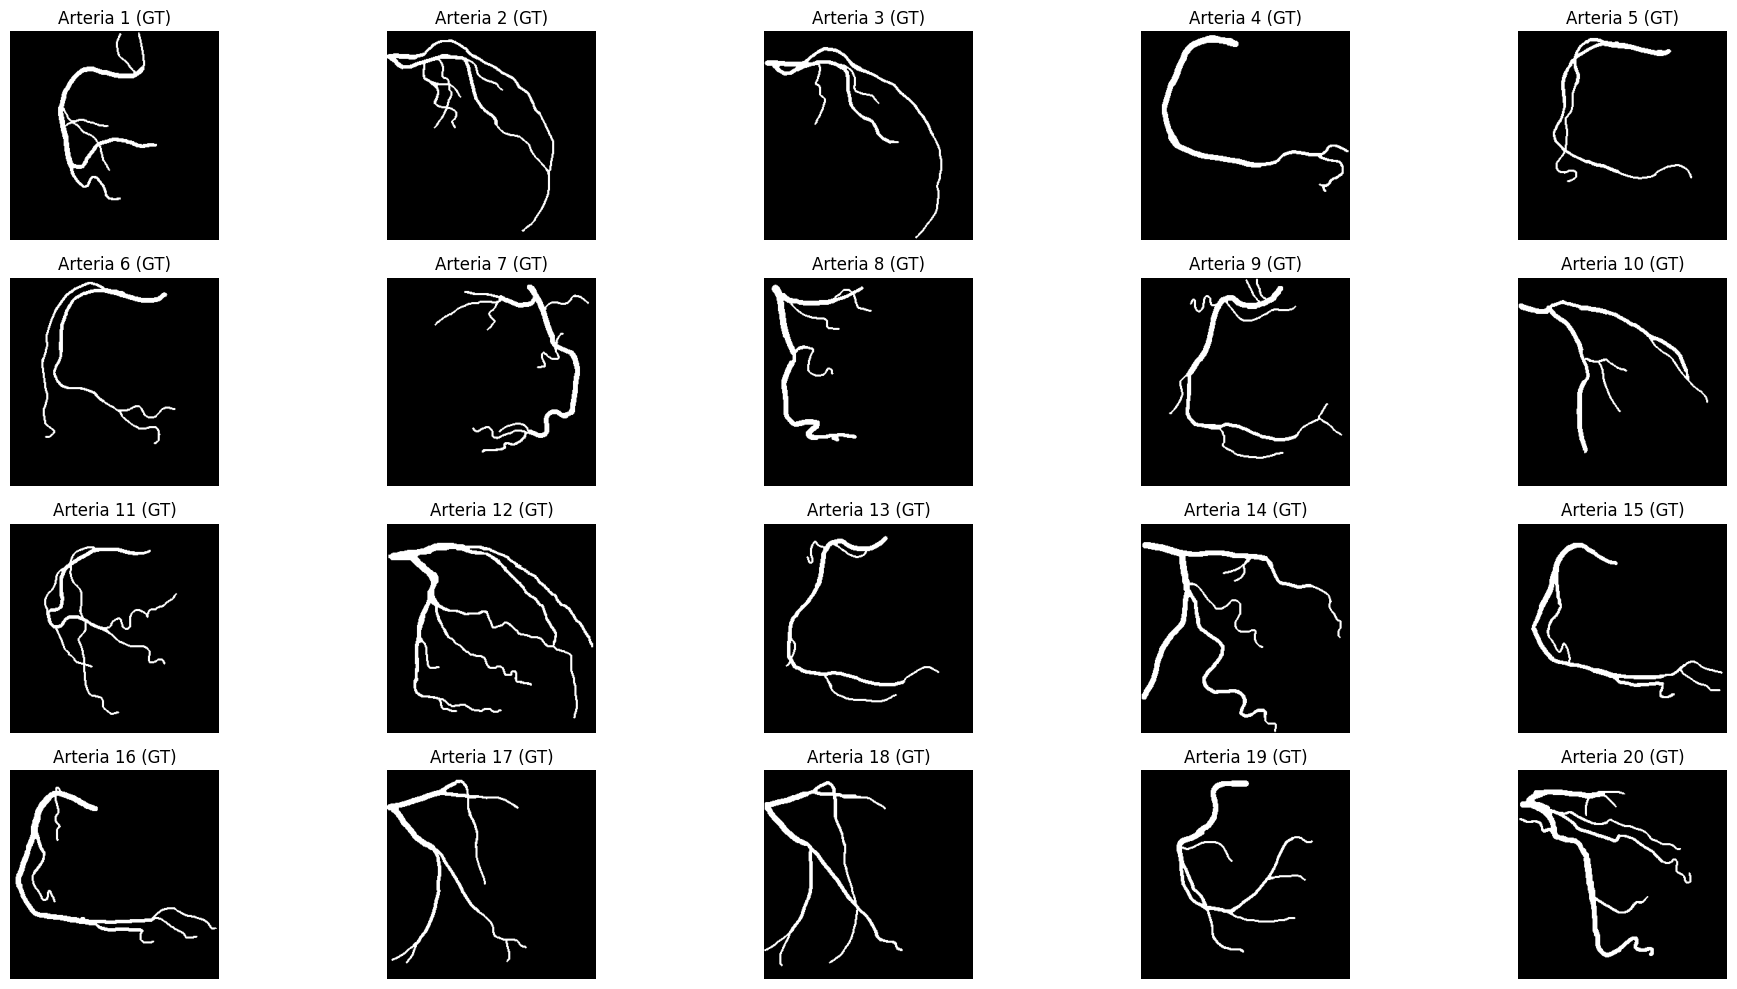

In [25]:

num_rows = 4
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

# Contador de subfiguras
index = 0

# Iterar sobre las imágenes y mostrarlas en la cuadrícula
for i in range(0, 20):  
    groundtruth_img = groundtruth_images[i]

    # Mostrar imagen groundtruth
    axes[index // num_cols, index % num_cols].imshow(groundtruth_img, cmap='gray')
    axes[index // num_cols, index % num_cols].axis('off')
    axes[index // num_cols, index % num_cols].set_title(f'Arteria {i + 1} (GT)')

    # Aumentar el contador de subfiguras
    index += 1  

# Ajustar el espacio entre las subfiguras
plt.tight_layout()

plt.show()


*Como se puede observar, hay varias imágenes originales en las que se ve el borde del microscopio (contornos negros en las esquinas). Asimismo, hay varias imágenes con manchas y sombras que pueden afectar el proceso de binarización. Como resultado, será necesario pre-procesar las imágenes.*

---------

#### *Pre-Procesamiento de Imágenes*

Posteriormente, se procede eliminar artefactos y ruido de las imágenes. 

- Como primer punto, se procede a aplicar un filtro gaussiano para suavizar la imagen y luego umbralizarla para obtener una imagen binaria que separe las arterias del fondo. Esto para binarizar la imagen, manteniendo las arterias y eliminando el fondo.

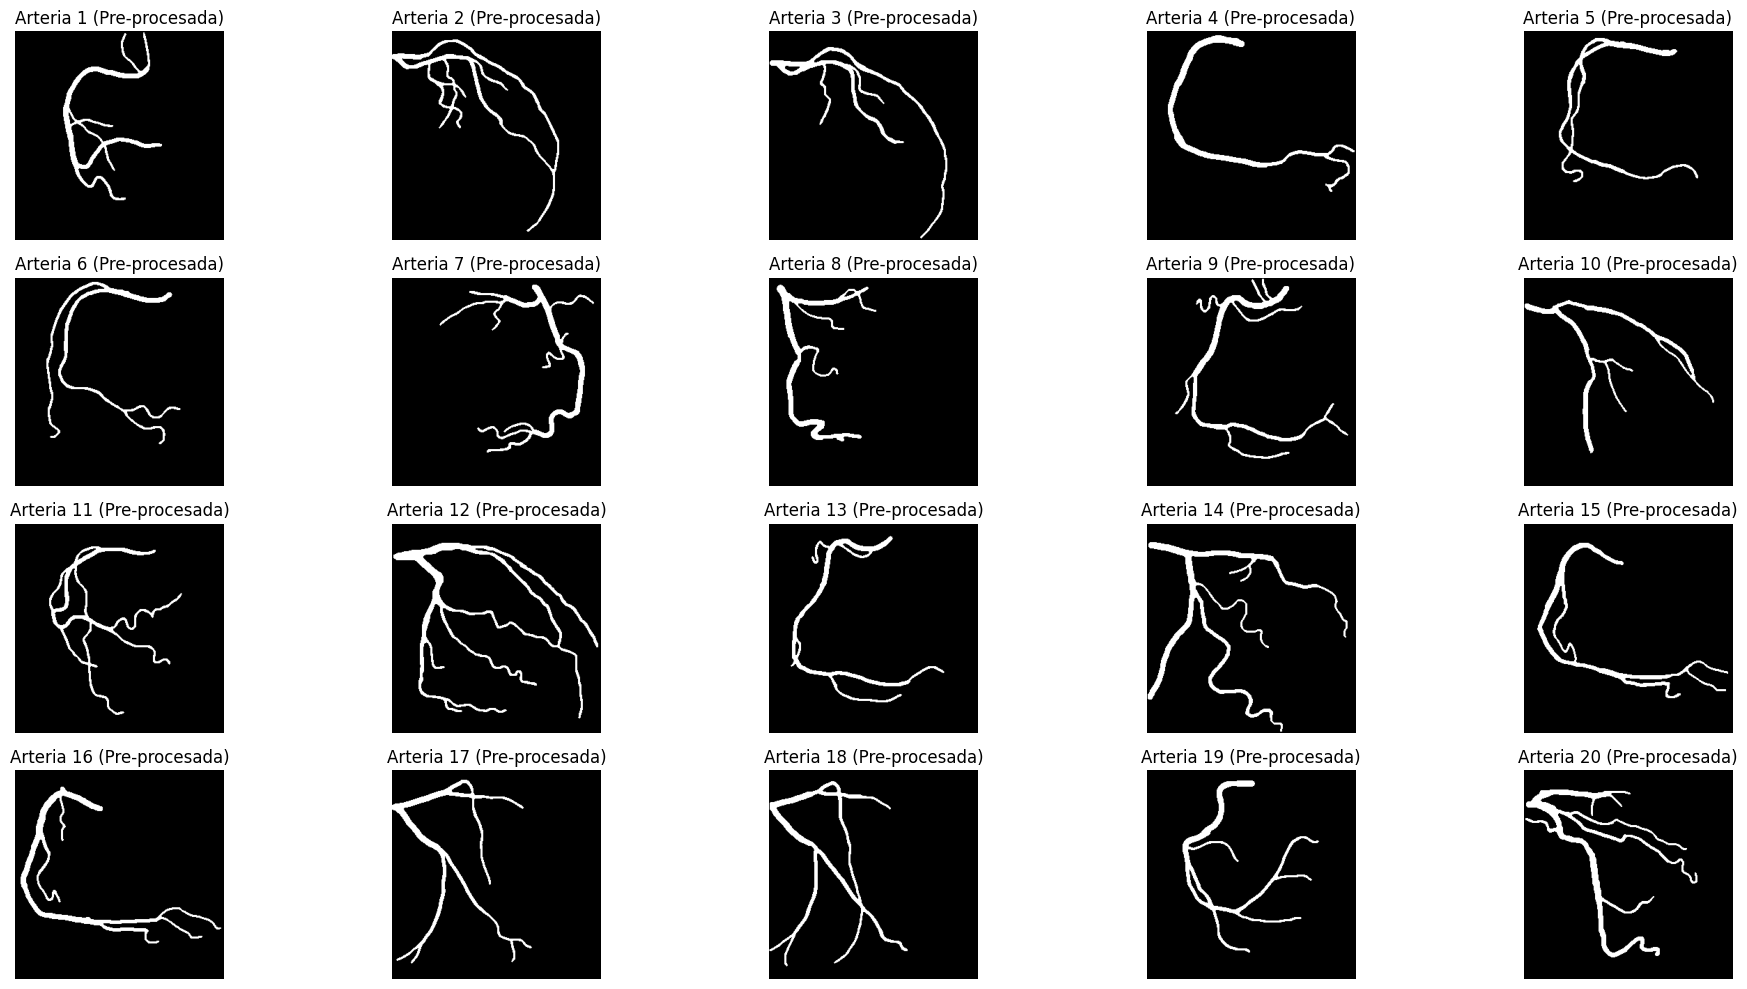

In [26]:
# Aplicar un filtro gaussiano para suavizar la imagen
smoothed_images = [gaussian(image, sigma=1) for image in groundtruth_images]

# Aplicar umbralización para convertir las imágenes a binario
# Este umbral puede ser global (simple) o adaptativo (local) dependiendo de las imágenes
thresholded_images = [image > threshold_otsu(image) for image in smoothed_images]

# Mostrar las imágenes pre-procesadas
num_rows = 4
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

# Contador de subfiguras
index = 0

# Iterar sobre las imágenes pre-procesadas y mostrarlas en la cuadrícula
for i in range(20):  
    # Mostrar imagen pre-procesada
    axes[index // num_cols, index % num_cols].imshow(thresholded_images[i], cmap='gray')
    axes[index // num_cols, index % num_cols].axis('off')
    axes[index // num_cols, index % num_cols].set_title(f'Arteria {i + 1} (Pre-procesada)')

    # Aumentar el contador de subfiguras
    index += 1  

# Ajustar el espacio entre las subfiguras
plt.tight_layout()
plt.show()


---------

#### *Detección de características*

Detectar puntos extremos, bifurcaciones y posiblemente trifurcaciones usando la transformada de Hough para detectar curvas o utilizando un análisis de la estructura de la imagen (como el análisis de esqueleto).

- Esqueletización: Se convierten las arterias a su forma esquelética, que es una representación de un píxel de ancho de las arterias.

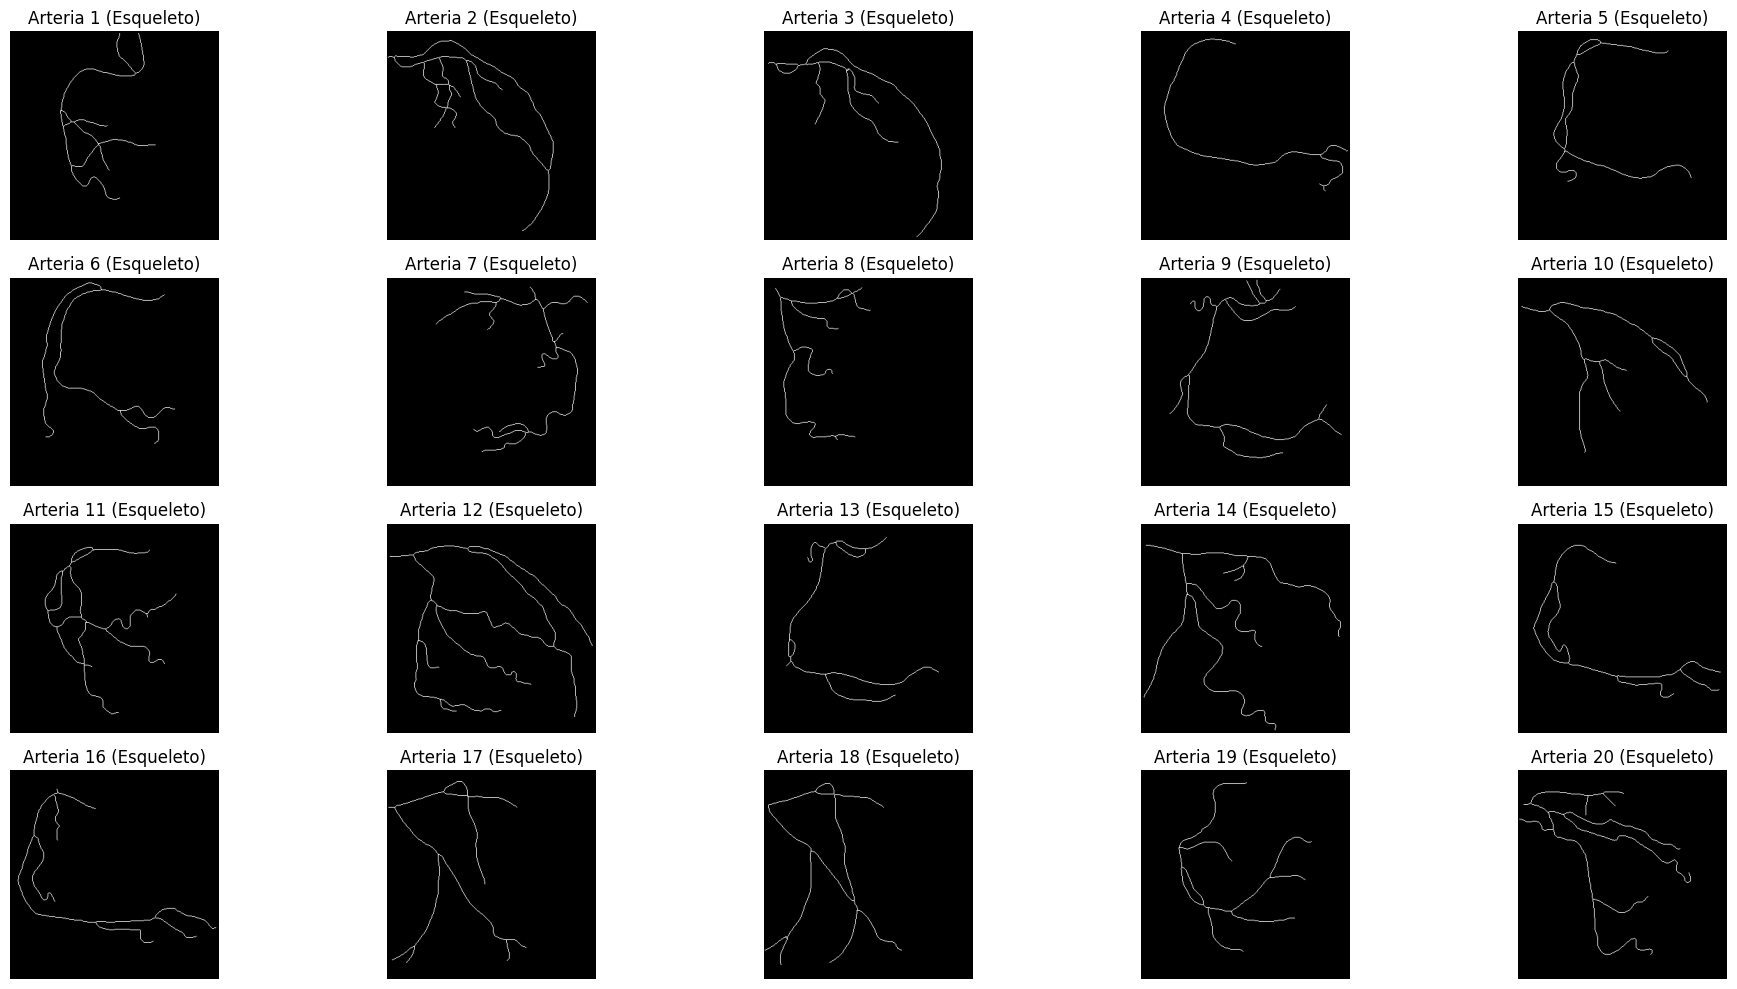

In [27]:
from skimage.morphology import skeletonize

skeleton_images = [skeletonize(image) for image in thresholded_images]

# Mostrar las imágenes esqueletizadas
num_rows = 4
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

# Contador de subfiguras
index = 0

# Iterar sobre las imágenes esqueletizadas y mostrarlas en la cuadrícula
for i in range(20):  # Asumiendo que hay 20 imágenes
    # Mostrar imagen esqueletizada
    axes[index // num_cols, index % num_cols].imshow(skeleton_images[i], cmap='gray')
    axes[index // num_cols, index % num_cols].axis('off')
    axes[index // num_cols, index % num_cols].set_title(f'Arteria {i + 1} (Esqueleto)')

    # Aumentar el contador de subfiguras
    index += 1  

# Ajustar el espacio entre las subfiguras
plt.tight_layout()
plt.show()


- Análisis de esqueleto: Se analiza el esqueleto para identificar nodos y conexiones. Los puntos de bifurcación son puntos donde un píxel tiene más de dos vecinos en el esqueleto, y los puntos extremos son aquellos que solo tienen un vecino.

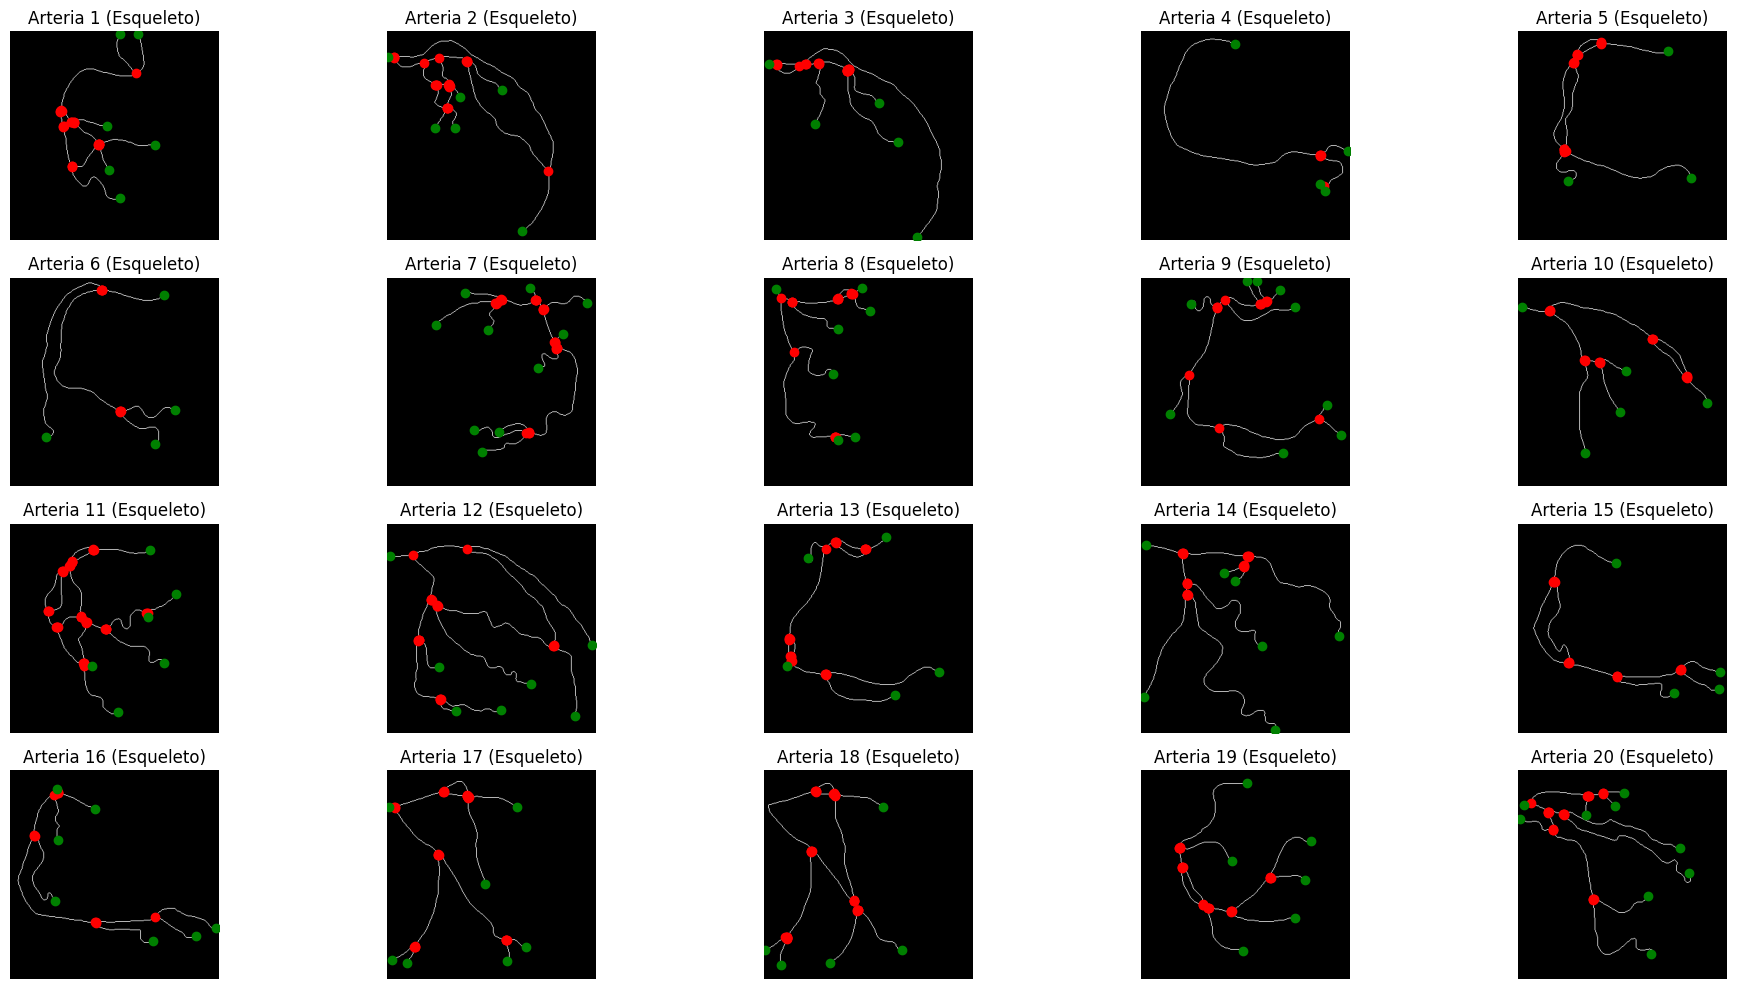

In [34]:
# Función para encontrar puntos de bifurcación y extremos en el esqueleto
def analyze_skeleton(skeleton):
    # Preparar arrays para almacenar las coordenadas de los puntos
    bifurcation_points = []
    endpoint_points = []
    
    # Obtener las dimensiones de la imagen
    dimensions = skeleton.shape
    
    # Analizar cada píxel del esqueleto
    for i in range(1, dimensions[0]-1):
        for j in range(1, dimensions[1]-1):
            # Contar los vecinos del píxel
            p = skeleton[i, j]
            neighbors = skeleton[i-1:i+2, j-1:j+2].sum() - p
            # Si el píxel es parte del esqueleto y tiene exactamente un vecino, es un extremo
            if p == 1 and neighbors == 1:
                endpoint_points.append((j, i))
            # Si el píxel es parte del esqueleto y tiene tres o más vecinos, es una bifurcación
            elif p == 1 and neighbors >= 3:
                bifurcation_points.append((j, i))
    
    return bifurcation_points, endpoint_points

# Encontrar puntos de bifurcación y extremos

analized_skeleton_images = [analyze_skeleton(image) for image in skeleton_images]

# Mostrar las imágenes esqueletizadas con puntos de bifurcación y extremos
num_rows = 4
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

# Contador de subfiguras
index = 0

# Iterar sobre las imágenes esqueletizadas y mostrarlas en la cuadrícula
for i in range(20):  # Asumiendo que hay 20 imágenes
    skeleton_image = skeleton_images[i]  # Esta es la imagen esqueletizada
    bifurcations, endpoints = analized_skeleton_images[i]  # Estos son los puntos detectados

    # Mostrar imagen esqueletizada
    axes[index // num_cols, index % num_cols].imshow(skeleton_image, cmap='gray')
    axes[index // num_cols, index % num_cols].scatter(*zip(*bifurcations), color='red')
    axes[index // num_cols, index % num_cols].scatter(*zip(*endpoints), color='green')
    axes[index // num_cols, index % num_cols].axis('off')
    axes[index // num_cols, index % num_cols].set_title(f'Arteria {i + 1} (Esqueleto)')

    # Aumentar el contador de subfiguras
    index += 1  

# Ajustar el espacio entre las subfiguras
plt.tight_layout()
plt.show()

- Añadir nodos intermedios: Se añaden nodos intermedios a lo largo de los segmentos arteriales para preservar la geometría de la arteria en el grafo.

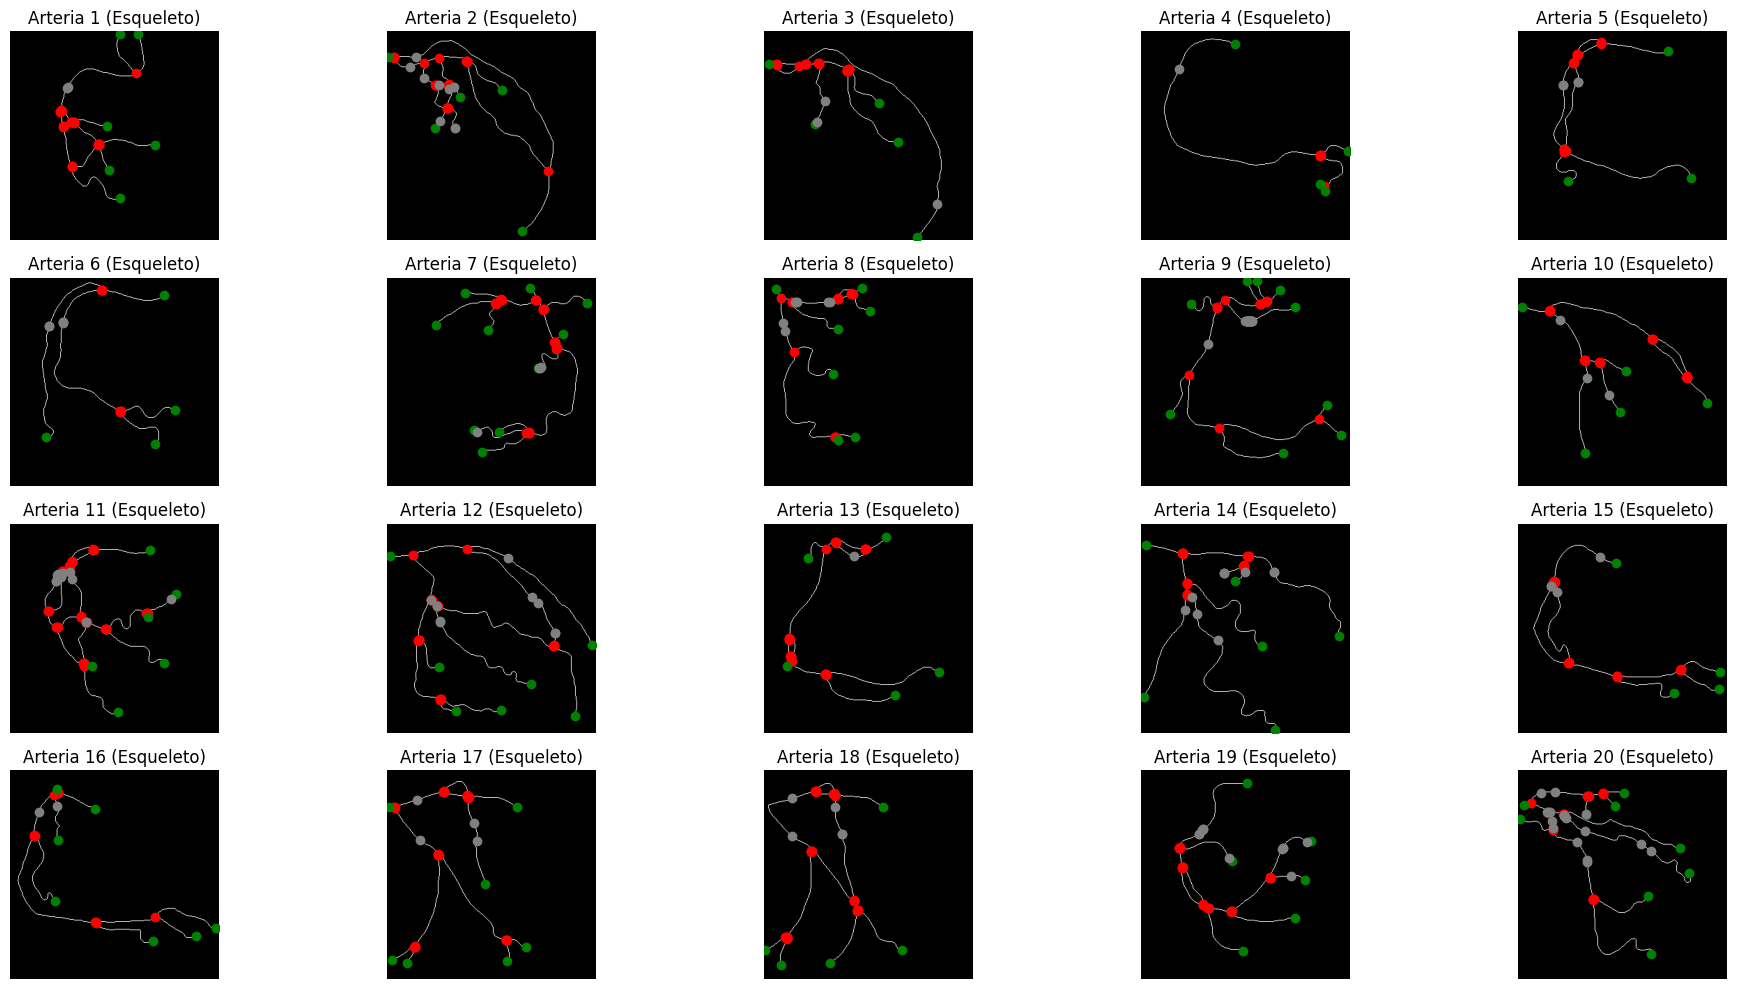

In [43]:
# Función para nodos intermedios a la visualización
def add_intermediate_nodes(skeleton):
    intermediate_nodes = []
    angles = calculate_angles(skeleton)

    for start, end, angle in angles:
        # Podemos agregar puntos intermedios entre los puntos de inicio y fin de los tramos con cambio de dirección
        # Esto es solo un ejemplo simple y puede necesitar ser más sofisticado para casos más complejos.
        intermediate_node = ((start[0] + end[0]) // 2, (start[1] + end[1]) // 2)
        if skeleton[intermediate_node[1], intermediate_node[0]]:  # Verificar que el punto esté en el esqueleto
            intermediate_nodes.append(intermediate_node)

    return intermediate_nodes

# Función para calcular los ángulos en cada punto del esqueleto
def calculate_angles(skeleton, angle_threshold=20):
    angles = []
    points = np.argwhere(skeleton)  # Obtener las coordenadas de los píxeles del esqueleto
    vectors = np.diff(points, axis=0)  # Calcular los vectores de dirección entre puntos consecutivos

    # Inicializar el primer punto y vector para la comparación
    prev_point = points[0]
    prev_vector = vectors[0] if len(vectors) > 0 else None

    for point, vector in zip(points[1:], vectors):
        # Normalizar los vectores para calcular el ángulo coseno
        unit_prev_vector = prev_vector / np.linalg.norm(prev_vector) if np.linalg.norm(prev_vector) else prev_vector
        unit_vector = vector / np.linalg.norm(vector) if np.linalg.norm(vector) else vector

        # Calcular el producto punto y el ángulo coseno entre los vectores
        dot_product = np.dot(unit_prev_vector, unit_vector)
        # Asegurarse de que el producto punto esté en el rango válido [-1, 1]
        dot_product = np.clip(dot_product, -1.0, 1.0)
        angle = np.arccos(dot_product)

        # Si el ángulo es significativo, entonces asumimos que hay un cambio de dirección
        if np.degrees(angle) > angle_threshold:
            angles.append((prev_point, point, np.degrees(angle)))

        # Actualizar el punto y vector previos
        prev_point = point
        prev_vector = vector

    return angles


completed_skeleton_images = []
for skeleton, (bifurcations, endpoints) in zip(skeleton_images, analized_skeleton_images):
    visualized_image = add_intermediate_nodes(skeleton)
    completed_skeleton_images.append(visualized_image)

# Mostrar las imágenes esqueletizadas con puntos de bifurcación y extremos
num_rows = 4
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

# Contador de subfiguras
index = 0

# Iterar sobre las imágenes esqueletizadas y mostrarlas en la cuadrícula
for i in range(20):  # Asumiendo que hay 20 imágenes
    skeleton_image = skeleton_images[i]  # Esta es la imagen esqueletizada
    bifurcations, endpoints = analized_skeleton_images[i]   #bifuraciones y enpoints
    intermediate_nodes = completed_skeleton_images[i] # puntos intermdios
    axes[index // num_cols, index % num_cols].imshow(skeleton_image, cmap='gray')
    axes[index // num_cols, index % num_cols].scatter(*zip(*bifurcations), color='red')
    axes[index // num_cols, index % num_cols].scatter(*zip(*endpoints), color='green')
    axes[index // num_cols, index % num_cols].scatter(*zip(*intermediate_nodes), color='gray')
    axes[index // num_cols, index % num_cols].axis('off')
    axes[index // num_cols, index % num_cols].set_title(f'Arteria {i + 1} (Esqueleto)')

    # Aumentar el contador de subfiguras
    index += 1  

# Ajustar el espacio entre las subfiguras
plt.tight_layout()
plt.show()


---------

#### *Construcción del grafo:*
Se utilizan los puntos identificados para construir un grafo en formato json
